In [29]:
from torch.nn import BCEWithLogitsLoss
import torch
import numpy as np
from func.network import VoxResNet, CellSegNet_basic_edge_gated
import matplotlib.pyplot as plt
import torch.nn as nn

In [30]:
load_path = 'output/model_HMS_2.pkl'
#load_path = 'output/model_HMS_delete_fake_cells.pkl'

# init model
model=CellSegNet_basic_edge_gated(input_channel=1, n_classes=3, output_func = "softmax")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)


<All keys matched successfully>

In [31]:
test_img = np.load("data/CellSeg_dataset/HMS_processed/raw/70.npy")

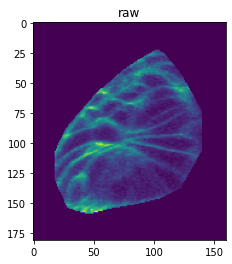

In [32]:
plt.figure()
plt.title("raw")
plt.imshow(test_img[:,150,:])

In [33]:
test_img_cropped = test_img[60:124, 100:164, 40:104]


In [34]:
raw_img_crop=torch.from_numpy(test_img_cropped).float().to(device)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
raw_img_crop = torch.unsqueeze(raw_img_crop, 0)
print(raw_img_crop.shape)
output_model, output_model_edge = model(raw_img_crop)

torch.Size([1, 1, 64, 64, 64])


In [35]:
output_model = output_model.detach().numpy()
output_model_edge = output_model_edge.detach().numpy()

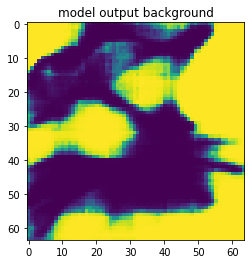

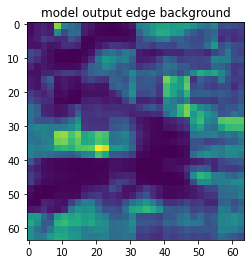

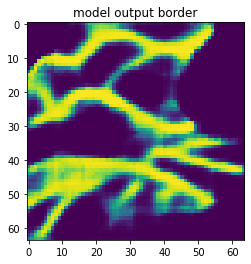

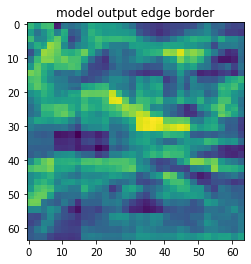

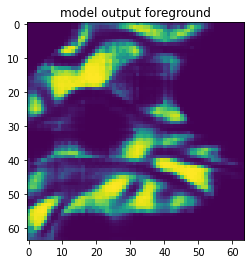

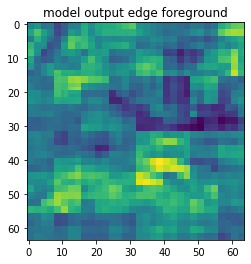

In [36]:
plt.figure()
plt.title("model output background")
plt.imshow(output_model[0,0,:,50,:])

plt.figure()
plt.title("model output edge background")
plt.imshow(output_model_edge[0,0,:,50,:])

plt.figure()
plt.title("model output border")
plt.imshow(output_model[0,1,:,50,:])

plt.figure()
plt.title("model output edge border")
plt.imshow(output_model_edge[0,1,:,50,:])

plt.figure()
plt.title("model output foreground")
plt.imshow(output_model[0,2,:,50,:])

plt.figure()
plt.title("model output edge foreground")
plt.imshow(output_model_edge[0,2,:,50,:])

In [37]:
np.unique(output_model)

array([2.5153307e-42, 2.8796683e-42, 3.2734332e-42, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

Investigate loss function



In [38]:
from func.loss_func import dice_loss_org
import torch.nn.functional as F

In [131]:
mock_target_1 = torch.tensor([[[1,0,0,0,0],
                               [0,1,0,0,0],
                               [0,0,1,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]]], dtype=torch.float)

mock_target_2 = torch.tensor([[[1,0,0,0,0],
                               [0,1,0,0,0],
                               [0,0,0,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]]], dtype=torch.float)

mock_output_1 = torch.tensor([[[1,0,0,0,0],
                               [0,1,0,0,0],
                               [0,0,1,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]]], dtype=torch.float)

mock_output_2 = torch.tensor([[[1,0,0,0,0],
                               [0,1,0,0,0],
                               [0,0,1,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]],
                              [[0,0,0,0,0],
                               [0,0,0,0,0],
                               [0,0,0,0,0]]], dtype=torch.float)

mock_target_1 = torch.unsqueeze(mock_target_1,dim=0)
mock_target_1 = torch.unsqueeze(mock_target_1,dim=0)

mock_target_2 = torch.unsqueeze(mock_target_2,dim=0)
mock_target_2 = torch.unsqueeze(mock_target_2,dim=0)

mock_output_1 = torch.unsqueeze(mock_output_1,dim=0)
mock_output_1 = torch.unsqueeze(mock_output_1,dim=0)

mock_output_2 = torch.unsqueeze(mock_output_2,dim=0)
mock_output_2 = torch.unsqueeze(mock_output_2,dim=0)


mock_target = torch.cat((mock_target_1, mock_target_2), dim=0)
mock_output = torch.cat((mock_output_1, mock_output_2), dim=0)

In [67]:
# is it per batch the same as if fed one by one?
print(f"dice loss for whole batch: {dice_loss_org(mock_target, mock_output)}")

dl_1 = dice_loss_org(mock_target_1, mock_output_1)
dl_2 = dice_loss_org(mock_target_2, mock_output_2)

print(f"dice loss for fed one by one: {dl_1 + dl_2}")
# --> not the same!

dice loss for whole batch: 0.1836734414100647
dice loss for fed one by one: 0.3257142901420593


In [216]:
def dice_loss_org_2(pred, target):
    """
    This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    smooth = 1

    # get batchsize
    N = pred.size(0)
    # have to use contiguous since they may from a torch.view op
    # iflat and tflat are of size (N, C*X*Y*Z)
    iflat = pred.contiguous().view(N, -1)
    tflat = target.contiguous().view(N, -1)

    intersection = 2. * torch.sum(torch.mul(iflat, tflat), dim=1)

    A_sum = torch.sum(torch.mul(iflat, iflat), dim=1)
    B_sum = torch.sum(torch.mul(tflat, tflat), dim=1)

    return torch.mean(1 - ((intersection + smooth) / (A_sum + B_sum + smooth)))

def dice_loss_org_3(pred, target):
    """
    This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    epsilon= 1e-7

    # get batchsize
    N = pred.size(0)
    # have to use contiguous since they may from a torch.view op
    # iflat and tflat are of size (N, C*X*Y*Z)
    iflat = pred.contiguous().view(N, -1)
    tflat = target.contiguous().view(N, -1)

    intersection = 2. * torch.sum(torch.mul(iflat, tflat), dim=1)

    A_sum = torch.sum(torch.mul(iflat, iflat), dim=1)
    B_sum = torch.sum(torch.mul(tflat, tflat), dim=1)

    return torch.mean(1 - ((intersection) / (A_sum + B_sum + epsilon)))

In [217]:
print(dice_loss_org_2(mock_target, mock_output))

print(dice_loss_org_3(mock_target, mock_output))



tensor(0.0556)
tensor(0.1000)


Weighted Binary Cross Entropy

In [212]:
def balanced_cross_entropy(pred, target):
    N = pred.size(0)
    iflat = pred.contiguous().view(N, -1)
    tflat = target.contiguous().view(N, -1)
    # parameter for weighting positive and negatives, beta is the percentage of non-edge voxels to edge voxels
    edge_percentage = torch.sum(tflat, dim=1) / tflat.size(dim=1)
    beta = 1. - edge_percentage

    tflat_inverted = 1 - tflat

    weight = torch.unsqueeze(beta, dim=1).expand_as(tflat) * tflat + \
             torch.unsqueeze(edge_percentage, dim=1).expand_as(tflat_inverted) * tflat_inverted

    return F.binary_cross_entropy(iflat, tflat, weight=weight)


In [213]:
balanced_cross_entropy(mock_output, mock_target)






number of edge pixels: tensor([3., 2.])
number of total pixels: torch.Size([45])
beta: tensor([0.9333, 0.9556])
torch.Size([2, 45])
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.9333, 0.0667, 0.0667, 0

tensor(0.0494)

In [41]:
F.binary_cross_entropy(mock_target, mock_output)

tensor(0.5556)

In [42]:
w = torch.tensor([0.1, 0.9], dtype=torch.float)
F.binary_cross_entropy(mock_target, mock_output, weight=w)

RuntimeError: The size of tensor a (5) must match the size of tensor b (2) at non-singleton dimension 4

In [ ]:
mock_target.shape

In [ ]:
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))

class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)


class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    The input to the loss function is assumed to be a logit and will be normalized by the Sigmoid function.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super().__init__(weight, normalization)

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)

In [ ]:
dice_loss = DiceLoss()

dice_loss.dice(mock_target, mock_output, weight= None)